Imports

In [ ]:
#  Install required libraries
# !pip install torch torchvision seaborn matplotlib

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.transforms.v2 import ToPILImage, ToImage
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from torch.utils.data import random_split, DataLoader
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import KFold
from joblib import Parallel, delayed
from scipy.ndimage import sobel
from Model_class import ConvNet
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score



device = 'cuda' if torch.cuda.is_available() else 'cpu'

Downloading Dataset from MNIST


In [2]:
train_transform = transforms.Compose([
    transforms.RandomRotation(10),  # Rotate by up to ±10 degrees
    transforms.RandomAffine(0, translate=(0.1, 0.1)),  # Random translation
    transforms.RandomAffine(0, scale=(0.9, 1.1)),  # Random scaling
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values
])

val_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Full MNIST training dataset
full_dataset = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=val_test_transform  # Use val_test_transform by default
)

# Split into train and validation subsets
train_size = int(0.95 * len(full_dataset))  # 95% for training
val_size = len(full_dataset) - train_size  # Remaining 5% for validation
train_indices, val_indices = random_split(range(len(full_dataset)), [train_size, val_size])

# Apply train_transform only to the train subset
train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=train_transform
)

val_dataset = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=val_test_transform  # No augmentation for validation
)

# Subset datasets using indices
train_dataset = torch.utils.data.Subset(train_dataset, train_indices)
val_dataset = torch.utils.data.Subset(val_dataset, val_indices)

# Test dataset (no augmentation)
test_dataset = datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=val_test_transform
)

Checking Target Class Distribution

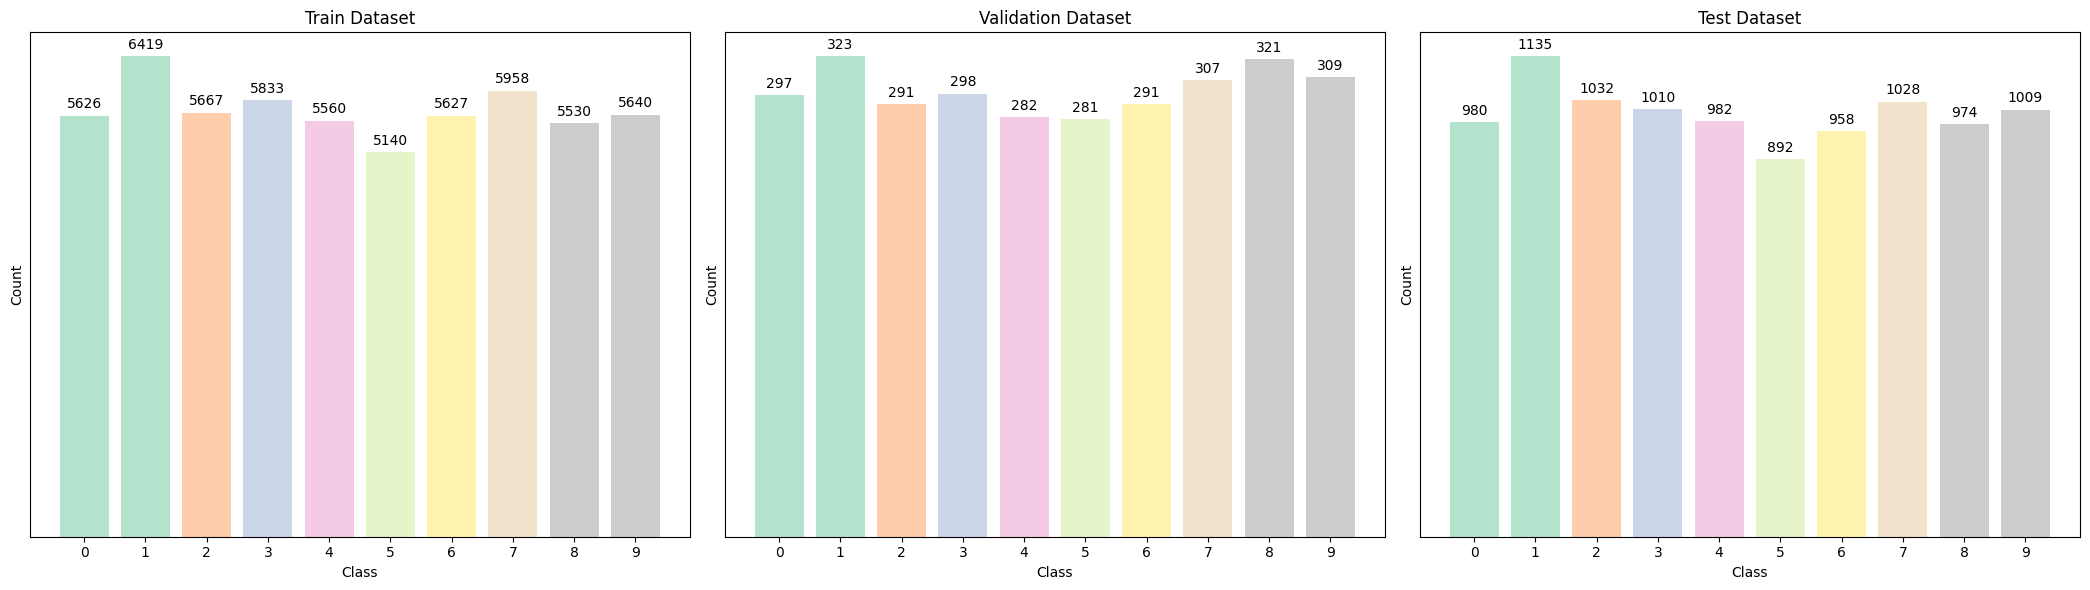

In [ ]:
def plot_class_distribution(dataset, title, ax):
    all_labels = [label for _, label in dataset]
    label_counts = Counter(all_labels)
    sorted_labels = sorted(label_counts.items(), key=lambda item: item[0])
    labels, counts = zip(*sorted_labels)

    bars = ax.bar(labels, counts, color=plt.cm.Pastel2(np.linspace(0, 1, len(labels))))
    ax.set_xlabel("Class")
    ax.set_ylabel("Count")
    ax.set_title(title)
    ax.set_xticks(labels)

    # Adjust the offset to be proportional to the count
    for bar, count in zip(bars, counts):
        ax.text(bar.get_x() + bar.get_width() / 2, count + 0.01 * count,  # 5% of the count
                 str(count), ha='center', va='bottom')
    ax.set_yticks([])

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(21, 6))  # 1 row, 3 columns

# Plot for each dataset
plot_class_distribution(train_dataset, "Train Dataset", axes[0])
plot_class_distribution(val_dataset, "Validation Dataset", axes[1])
plot_class_distribution(test_dataset, "Test Dataset", axes[2])

plt.tight_layout()
plt.show()

*Target Class is evenly distributed*

# Cross Validation

In [ ]:
# Cross-validation function version -2
def train_and_evaluate(params):
    learning_rate = params['learning_rate']
    batch_size = params['batch_size']
    dropout = params['dropout']

    # Initialize model, loss, and optimizer
    model = ConvNet(dropout=dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # K-Fold Cross-Validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    accuracies = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(train_dataset)):
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        # Training loop
        for epoch in range(5):  # Keep epochs small for tuning
            model.train()
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

        # Validation loop
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Calculate accuracy for the current fold
        fold_accuracy = correct / total
        accuracies.append(fold_accuracy)

    # Calculate mean accuracy across folds
        mean_accuracy = np.mean(accuracies)
        print(f"Evaluated -> LR: {learning_rate}, Batch Size: {batch_size}, Dropout: {dropout}, "
          f"Mean Accuracy: {mean_accuracy:.4f}")

    return mean_accuracy

In [ ]:
# Hyperparameter grid
param_grid = {
    'learning_rate': [0.001, 0.01],
    'batch_size': [32, 64],
    'dropout': [0.3, 0.5]
}

results = Parallel(n_jobs=-1)(delayed(train_and_evaluate)(params)
                              for params in [
                                  {'learning_rate': lr, 'batch_size': bs, 'dropout': dr}
                                  for lr in param_grid['learning_rate']
                                  for bs in param_grid['batch_size']
                                  for dr in param_grid['dropout']
                              ])


best_accuracy = max(results)
best_params_idx = results.index(best_accuracy)
best_params = [
    {'learning_rate': lr, 'batch_size': bs, 'dropout': dr}
    for lr in param_grid['learning_rate']
    for bs in param_grid['batch_size']
    for dr in param_grid['dropout']
][best_params_idx]

print("Best Parameters:", best_params)
print("Best Accuracy:", best_accuracy)

Best Parameters: {'learning_rate': 0.001, 'batch_size': 32, 'dropout': 0.3}
Best Accuracy: 0.991


# Final Model

In [3]:
Best_Parameters = {'learning_rate': 0.001, 'batch_size': 32, 'dropout': 0.3}

final_model = ConvNet(dropout=Best_Parameters['dropout']).to(device)
final_optimizer = optim.Adam(final_model.parameters(), lr=Best_Parameters['learning_rate'])
final_criterion = nn.CrossEntropyLoss()
final_batch_size = Best_Parameters['batch_size']
epochs = 20

train_loader = DataLoader(train_dataset, batch_size=final_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=final_batch_size)

train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []

for epoch in range(epochs):
    # Training phase
    final_model.train()
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        final_optimizer.zero_grad()
        outputs = final_model(inputs)
        loss = final_criterion(outputs, labels)
        loss.backward()
        final_optimizer.step()

        total_train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    # Calculate average training loss and accuracy
    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = correct_train / total_train

    train_loss_list.append(avg_train_loss)
    train_acc_list.append(train_accuracy)

    # Validation phase
    final_model.eval()
    y_true = []
    y_pred = []
            
    total_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = final_model(inputs)
            loss = final_criterion(outputs, labels)

            total_val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    # Calculate average validation loss and accuracy
    avg_val_loss = total_val_loss / len(test_loader)
    val_accuracy = correct_val / total_val

    val_loss_list.append(avg_val_loss)
    val_acc_list.append(val_accuracy)

    print(f"Epoch {epoch+1}/{epochs}, "
          f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

# Save the model
torch.save(final_model.state_dict(), 'mnist_model.pth')


Epoch 1/20, Train Loss: 0.4602, Train Accuracy: 0.8511, Val Loss: 0.0724, Val Accuracy: 0.9765
Epoch 2/20, Train Loss: 0.1849, Train Accuracy: 0.9433, Val Loss: 0.0469, Val Accuracy: 0.9843
Epoch 3/20, Train Loss: 0.1540, Train Accuracy: 0.9541, Val Loss: 0.0430, Val Accuracy: 0.9852
Epoch 4/20, Train Loss: 0.1324, Train Accuracy: 0.9598, Val Loss: 0.0330, Val Accuracy: 0.9893
Epoch 5/20, Train Loss: 0.1171, Train Accuracy: 0.9650, Val Loss: 0.0386, Val Accuracy: 0.9878
Epoch 6/20, Train Loss: 0.1101, Train Accuracy: 0.9674, Val Loss: 0.0359, Val Accuracy: 0.9884
Epoch 7/20, Train Loss: 0.1040, Train Accuracy: 0.9692, Val Loss: 0.0329, Val Accuracy: 0.9897
Epoch 8/20, Train Loss: 0.1008, Train Accuracy: 0.9699, Val Loss: 0.0341, Val Accuracy: 0.9897
Epoch 9/20, Train Loss: 0.0936, Train Accuracy: 0.9713, Val Loss: 0.0314, Val Accuracy: 0.9900
Epoch 10/20, Train Loss: 0.0933, Train Accuracy: 0.9708, Val Loss: 0.0308, Val Accuracy: 0.9911
Epoch 11/20, Train Loss: 0.0909, Train Accuracy: 

In [14]:
def create_performance_report(train_loss_list, val_loss_list, 
                            train_acc_list, val_acc_list,
                            y_true, y_pred, epochs):
    """
    Creates a comprehensive performance report with multiple subplots
    showing training history, metrics, and confusion matrices.
    """
    # Set the style - using default matplotlib style
    plt.style.use('default')
    # Apply seaborn styling properties
    sns.set_context("notebook", font_scale=1.0)
    
    # Create figure with GridSpec
    fig = plt.figure(figsize=(20, 15))
    gs = fig.add_gridspec(3, 2)
    
    # Training History Plots
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    plot_training_history(train_loss_list, val_loss_list, epochs, "Loss", ax1)
    plot_training_history(train_acc_list, val_acc_list, epochs, "Accuracy", ax2)
    
    # Metrics Plot
    ax3 = fig.add_subplot(gs[1, :])
    metrics = calculate_metrics(y_true, y_pred)
    plot_metrics(metrics, ax3)
    
    # Confusion Matrices
    ax4 = fig.add_subplot(gs[2, 0])
    ax5 = fig.add_subplot(gs[2, 1])
    plot_confusion_matrices(y_true, y_pred, ax4, ax5)
    
    # Adjust layout
    plt.tight_layout()
    return fig

def plot_training_history(train_data, val_data, epochs, metric_name, ax):
    """Plot training and validation metrics."""
    epochs_range = range(1, epochs + 1)
    ax.plot(epochs_range, train_data, 'b-', label=f'Training {metric_name}', linewidth=2)
    ax.plot(epochs_range, val_data, 'r--', label=f'Validation {metric_name}', linewidth=2)
    ax.set_xlabel('Epochs', fontsize=10)
    ax.set_ylabel(metric_name, fontsize=10)
    ax.set_title(f'Training and Validation {metric_name}', fontsize=12, pad=10)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend(fontsize=10)
    ax.tick_params(labelsize=8)

def calculate_metrics(y_true, y_pred):
    """Calculate various performance metrics."""
    return {
        'F1-Score': f1_score(y_true, y_pred, average='macro'),
        'Precision': precision_score(y_true, y_pred, average='macro'),
        'Recall': recall_score(y_true, y_pred, average='macro'),
        'Accuracy': accuracy_score(y_true, y_pred)
    }

def plot_metrics(metrics, ax):
    """Create a horizontal bar plot of metrics."""
    colors = sns.color_palette("Pastel2", len(metrics))
    bars = ax.barh(list(metrics.keys()), list(metrics.values()), color=colors)
    ax.set_xlim(0, 1)
    ax.set_xlabel('Score', fontsize=12)
    ax.set_title('Model Performance Metrics', fontsize=12, pad=10)
    ax.grid(True, axis='x', linestyle='--', alpha=0.7)
    
    # Add value labels
    for bar in bars:
        width = bar.get_width()
        ax.text(width + 0.01, bar.get_y() + bar.get_height()/2,
                f'{width:.4f}', va='center', fontsize=12)
    
    ax.tick_params(labelsize=12)

def plot_confusion_matrices(y_true, y_pred, ax1, ax2):
    """Plot confusion matrices with raw counts and percentages."""
    cm = confusion_matrix(y_true, y_pred)
    
    # Raw counts
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=range(10), yticklabels=range(10),
                ax=ax1, cbar=True)
    ax1.set_xlabel('Predicted Label', fontsize=10)
    ax1.set_ylabel('True Label', fontsize=10)
    ax1.set_title('Confusion Matrix (Raw Counts)', fontsize=12, pad=10)
    ax1.tick_params(labelsize=8)
    
    # Percentages
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    sns.heatmap(cm_percentage, annot=True, fmt='.1f', cmap='Blues',
                xticklabels=range(10), yticklabels=range(10),
                ax=ax2, cbar=True)
    ax2.set_xlabel('Predicted Label', fontsize=10)
    ax2.set_ylabel('True Label', fontsize=10)
    ax2.set_title('Confusion Matrix (Percentages)', fontsize=12, pad=10)
    ax2.tick_params(labelsize=8)

def display_images_and_predictions(images, labels, model, transform, device):
    """
    Function to display a batch of images, make predictions and compare with actual labels.
    """
    # Display the first 6 images in the batch with their corresponding labels
    print("Sample Images from Training Batch", "\n")
    fig, axes = plt.subplots(1, 6, figsize=(12, 2))
    for i in range(6):
        axes[i].imshow(images[i].squeeze(), cmap='gray')  # Remove singleton dimensions
        axes[i].set_title(f"Label: {labels[i].item()}")
        axes[i].axis('off')
    plt.show()

    # Now perform inference for all images in the batch
    with torch.no_grad():  # No need to track gradients during inference
        images = images.to(device)  # Move images to the correct device (CPU/GPU)
        outputs = model(images)  # Model inference
        _, predicted = torch.max(outputs, 1)  # Get predicted class

    # Display predictions and actual labels for comparison
    for i in range(min(6, len(images))):  # Display up to 6 images
        print(f"Predicted: {predicted[i].item()} | Actual: {labels[i].item()}")

# Report of Final Model

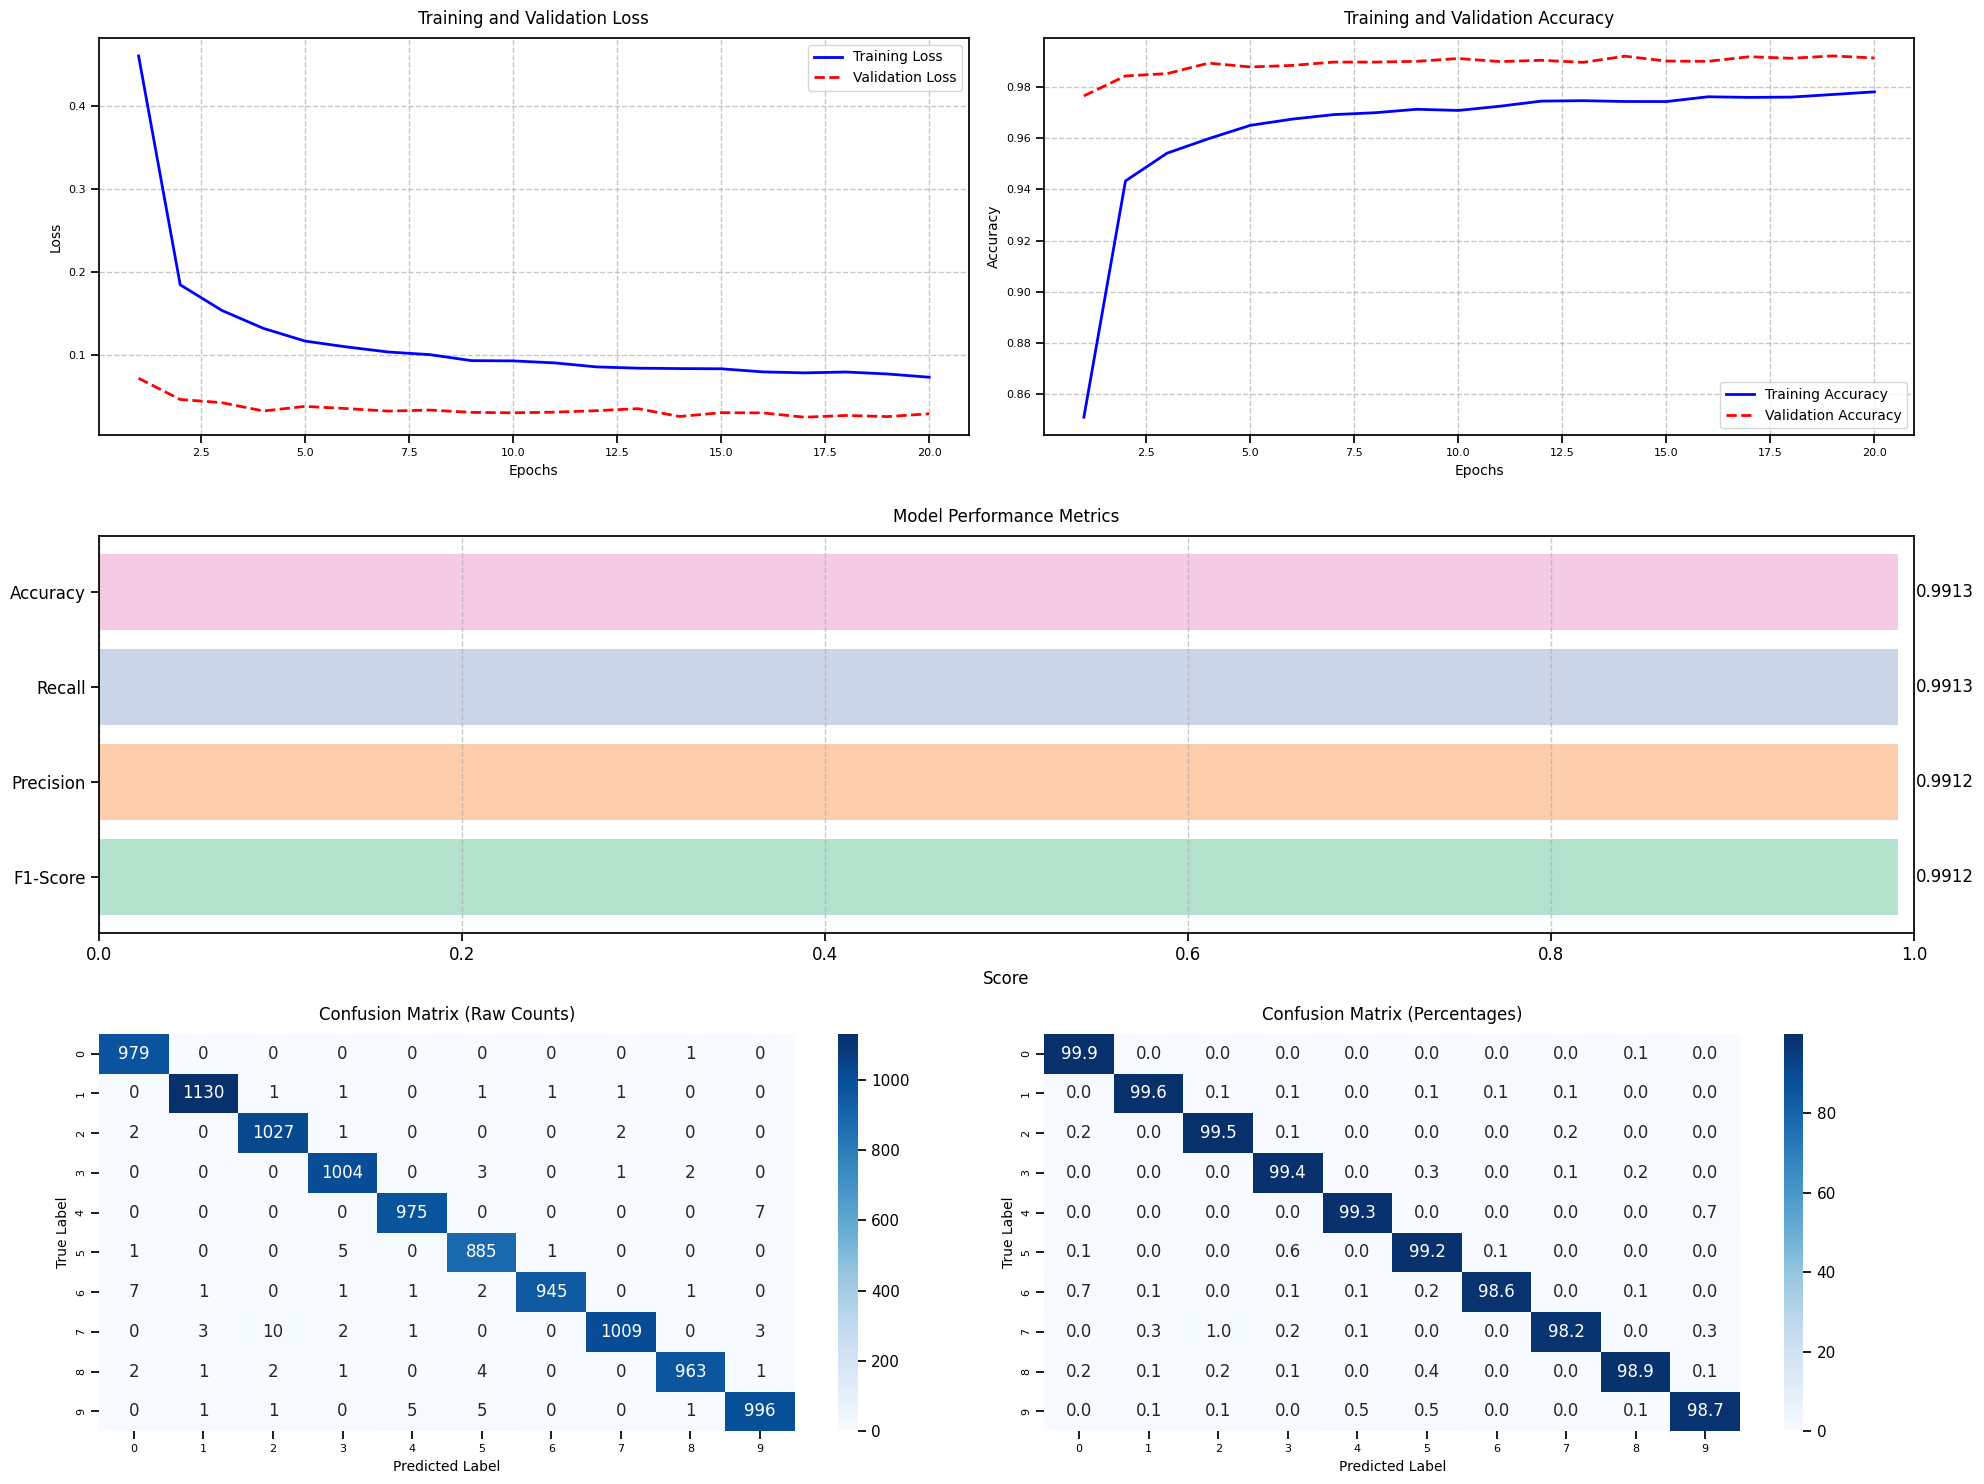

In [15]:
fig = create_performance_report(
    train_loss_list, val_loss_list,
    train_acc_list, val_acc_list,
    y_true, y_pred,
    epochs=20
)
plt.show()

# Sample Prediction with saved Model

In [6]:
model = ConvNet()  
model.load_state_dict(torch.load('mnist_model.pth')) 
model.eval()

C:\Users\RAJ\AppData\Local\Temp\ipykernel_5460\2642221250.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('mnist_model.pth'))


ConvNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (dropout): Dropout(p=0.0, inplace=False)
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Model Prediction:
Sample Images from Training Batch 



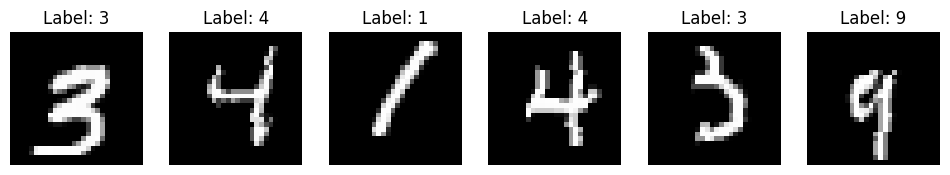

Predicted: 3 | Actual: 3
Predicted: 4 | Actual: 4
Predicted: 1 | Actual: 1
Predicted: 4 | Actual: 4
Predicted: 3 | Actual: 3
Predicted: 9 | Actual: 9
Sample Images from Training Batch 



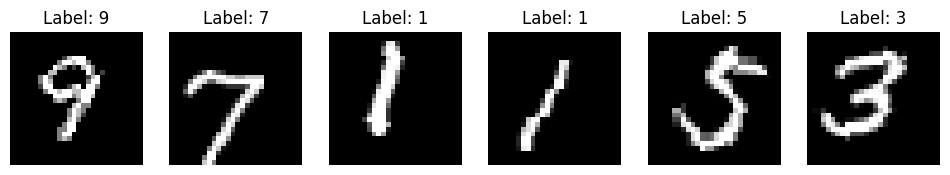

Predicted: 9 | Actual: 9
Predicted: 7 | Actual: 7
Predicted: 1 | Actual: 1
Predicted: 1 | Actual: 1
Predicted: 5 | Actual: 5
Predicted: 3 | Actual: 3


In [9]:
print("Model Prediction:")
# Get one batch of data
examples = iter(train_loader)

for _ in range(2):
    images, labels = next(examples)
    display_images_and_predictions(images, labels, model, val_test_transform, device)